In [10]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import copy
import gc

In [11]:
def load_cifar10(data_dir):
    """加载 CIFAR - 10 数据"""
    X_train = []
    y_train = []
    for i in range(1, 6):
        with open(os.path.join(data_dir, f'data_batch_{i}'), 'rb') as f:
            batch = pickle.load(f, encoding='latin1')
            X_train.append(batch['data'])
            y_train.extend(batch['labels'])
    X_train = np.concatenate(X_train)
    y_train = np.array(y_train)

    with open(os.path.join(data_dir, 'test_batch'), 'rb') as f:
        batch = pickle.load(f, encoding='latin1')
        X_test = batch['data']
        y_test = np.array(batch['labels'])

    return X_train, y_train, X_test, y_test

In [12]:
def preprocess_data(X_train, X_test):
    """数据预处理：归一化、标准化"""
    X_train = X_train.astype(np.float32).reshape(-1, 32 * 32 * 3)
    X_test = X_test.astype(np.float32).reshape(-1, 32 * 32 * 3)

    # 计算均值和标准差
    mean = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)
    std[std == 0] = 1  # 防止除零错误

    X_train = (X_train - mean) / std
    X_test = (X_test - mean) / std
    return X_train, X_test

In [13]:
class ThreeLayerNet:
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes, std=1e-4, activation='relu'):
        """
        初始化三层网络
        :param input_size: 输入维度
        :param hidden_size1: 第一个隐藏层维度
        :param hidden_size2: 第二个隐藏层维度
        :param num_classes: 类别数
        :param activation: 激活函数类型
        """
        self.params = {}
        # He初始化
        self.params['W1'] = np.random.randn(input_size, hidden_size1).astype(np.float32) * np.sqrt(2 / input_size)
        self.params['b1'] = np.zeros(hidden_size1, dtype=np.float32)
        self.params['W2'] = np.random.randn(hidden_size1, hidden_size2).astype(np.float32) * np.sqrt(2 / hidden_size1)
        self.params['b2'] = np.zeros(hidden_size2, dtype=np.float32)
        self.params['W3'] = (std * np.random.randn(hidden_size2, num_classes)).astype(np.float32)
        self.params['b3'] = np.zeros(num_classes, dtype=np.float32)
        self.activation = activation
        if self.activation == 'prelu':
            self.params['alpha1'] = np.ones(hidden_size1, dtype=np.float32) * 0.25
            self.params['alpha2'] = np.ones(hidden_size2, dtype=np.float32) * 0.25

    def relu(self, x, derivative=False):
        """ReLU激活函数及其导数"""
        if not derivative:
            return np.maximum(0, x)
        return (x > 0).astype(np.float32)

    def prelu(self, x, alpha, derivative=False):
        """PReLU激活函数及其导数"""
        if not derivative:
            alpha = alpha.reshape(1, -1)
            return np.maximum(0, x) + alpha * np.minimum(0, x)
        dx = np.ones_like(x, dtype=np.float32)
        alpha = alpha.reshape(1, -1)
        idx = x < 0
        dx[idx] = alpha[0, np.where(idx)[1]]
        return dx

    def leaky_relu(self, x, alpha=0.01, derivative=False):
        """LeakyReLU激活函数及其导数"""
        if not derivative:
            return np.maximum(alpha * x, x)
        dx = np.ones_like(x, dtype=np.float32)
        dx[x < 0] = alpha
        return dx

    def tanh(self, x, derivative=False):
        """Tanh激活函数及其导数"""
        tanh_x = np.tanh(x)
        if not derivative:
            return tanh_x
        return 1 - tanh_x ** 2

    def activate(self, x, derivative=False):
        """根据激活函数类型调用相应的激活函数"""
        if self.activation == 'relu':
            return self.relu(x, derivative)
        elif self.activation == 'prelu':
            if x.ndim == 2:
                if x.shape[1] == self.params['alpha1'].shape[0]:
                    alpha = self.params['alpha1']
                else:
                    alpha = self.params['alpha2']
            if not derivative:
                return self.prelu(x, alpha)
            return self.prelu(x, alpha, derivative)
        elif self.activation == 'leaky_relu':
            return self.leaky_relu(x, derivative=derivative)
        elif self.activation == 'tanh':
            return self.tanh(x, derivative)

    def forward(self, X):
        """前向传播"""
        cache = {}
        # 第一层
        z1 = np.dot(X, self.params['W1']) + self.params['b1']
        a1 = self.activate(z1)
        # 第二层
        z2 = np.dot(a1, self.params['W2']) + self.params['b2']
        a2 = self.activate(z2)
        # 第三层
        z3 = np.dot(a2, self.params['W3']) + self.params['b3']

        cache = {
            'z1': z1, 'a1': a1,
            'z2': z2, 'a2': a2,
            'z3': z3
        }
        return z3, cache

    def cross_entropy_loss(self, scores, y, reg=0.0):
        """计算交叉熵损失 + L2正则化"""
        num_samples = y.shape[0]
        exp_scores = np.exp(scores - np.max(scores, axis=1, keepdims=True))
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        loss = -np.sum(np.log(probs[np.arange(num_samples), y])) / num_samples

        # L2正则化
        reg_loss = 0.5 * reg * (
                np.sum(self.params['W1'] ** 2) +
                np.sum(self.params['W2'] ** 2) +
                np.sum(self.params['W3'] ** 2)
        )
        return loss + reg_loss

    def backward(self, X, y, scores, cache, reg=0.0):
        """反向传播计算梯度"""
        grads = {}
        num_samples = X.shape[0]
        z1, a1, z2, a2, z3 = cache['z1'], cache['a1'], cache['z2'], cache['a2'], cache['z3']

        # 第三层梯度
        dscores = scores.copy()
        dscores[np.arange(num_samples), y] -= 1
        dscores /= num_samples

        grads['W3'] = np.dot(a2.T, dscores) + reg * self.params['W3']
        grads['b3'] = np.sum(dscores, axis=0)

        # 第二层梯度
        da2 = np.dot(dscores, self.params['W3'].T)
        dz2 = da2 * self.activate(z2, derivative=True)
        grads['W2'] = np.dot(a1.T, dz2) + reg * self.params['W2']
        grads['b2'] = np.sum(dz2, axis=0)

        # 第一层梯度
        da1 = np.dot(dz2, self.params['W2'].T)
        dz1 = da1 * self.activate(z1, derivative=True)
        grads['W1'] = np.dot(X.T, dz1) + reg * self.params['W1']
        grads['b1'] = np.sum(dz1, axis=0)

        if self.activation == 'prelu':
            grads['alpha1'] = np.sum(da1 * (z1 < 0), axis=0)
            grads['alpha2'] = np.sum(da2 * (z2 < 0), axis=0)

        return grads

In [21]:
def hyperparameter_search(X_train, y_train, X_val, y_val,
                          learning_rates, hidden_sizes, regs, activations, epochs=5):
    """超参数搜索"""
    results = {}
    all_train_losses = {}
    all_val_losses = {}
    all_val_accuracies = {}
    for lr in learning_rates:
        for hs in hidden_sizes:
            for reg in regs:
                for activation in activations:
                    hidden_size1, hidden_size2 = hs
                    net = ThreeLayerNet(
                        input_size=32 * 32 * 3,
                        hidden_size1=hidden_size1,
                        hidden_size2=hidden_size2,
                        num_classes=10,
                        activation=activation
                    )
                    print(f"开始训练超参数组合: LR={lr}, HS={hs}, Reg={reg}, Activation={activation}")
                    trained_net, train_losses, val_losses, val_accuracies = train_model(
                        net, X_train, y_train, X_val, y_val,
                        learning_rate=lr, reg=reg, epochs=epochs, verbose=True
                    )
                    val_scores, _ = trained_net.forward(X_val)
                    val_acc = np.mean(np.argmax(val_scores, axis=1) == y_val)
                    hparams = (lr, hs, reg, activation)
                    results[hparams] = val_acc
                    all_train_losses[hparams] = train_losses
                    all_val_losses[hparams] = val_losses
                    all_val_accuracies[hparams] = val_accuracies
                    print(f'LR: {lr}, HS: {hs}, Reg: {reg}, Activation: {activation}, Val Acc: {val_acc}')
                    # 保存权重、准确率和损失
                    save_weights(trained_net, hparams, val_acc, train_losses[-1], val_losses[-1])
                    # 手动触发垃圾回收
                    del trained_net, val_scores
                    gc.collect()
    return results, all_train_losses, all_val_losses, all_val_accuracies

In [15]:
def test_model(net, X_test, y_test):
    """测试模型"""
    test_scores, _ = net.forward(X_test)
    pred = np.argmax(test_scores, axis=1)
    accuracy = np.mean(pred == y_test)
    print(f'Test Accuracy: {accuracy}')
    return accuracy

In [16]:
def visualize_curves(train_losses, val_losses, val_accuracies, best_hparams):
    """可视化曲线"""
    lr, hs, reg, activation = best_hparams
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training Loss - LR: {lr}, HS: {hs}, Reg: {reg}, Activation: {activation}')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Validation Loss - LR: {lr}, HS: {hs}, Reg: {reg}, Activation: {activation}')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(val_accuracies, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Validation Accuracy - LR: {lr}, HS: {hs}, Reg: {reg}, Activation: {activation}')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [17]:
def sgd_update(net, grads, learning_rate):
    """SGD参数更新"""
    for param in grads:
        net.params[param] -= learning_rate * grads[param]

In [23]:
def train_model(net, X_train, y_train, X_val, y_val,
                learning_rate=1e-3, reg=0.0, epochs=10,
                batch_size=64, verbose=False, lr_decay=0.95, decay_every=1,
                patience=20):
    """训练模型"""
    best_acc = 0.0
    best_weights = copy.deepcopy(net.params)
    train_losses = []
    val_losses = []
    val_accuracies = []
    num_samples = X_train.shape[0]
    num_batches = num_samples // batch_size
    no_improvement_count = 0

    for epoch in range(epochs):
        if epoch % decay_every == 0 and epoch > 0:
            learning_rate *= lr_decay
        epoch_train_loss = 0
        for batch in range(num_batches):
            start_idx = batch * batch_size
            end_idx = start_idx + batch_size
            X_batch = X_train[start_idx:end_idx]
            y_batch = y_train[start_idx:end_idx]

            scores, cache = net.forward(X_batch)
            loss = net.cross_entropy_loss(scores, y_batch, reg)
            epoch_train_loss += loss
            grads = net.backward(X_batch, y_batch, scores, cache, reg)
            sgd_update(net, grads, learning_rate)

        epoch_train_loss /= num_batches
        train_losses.append(epoch_train_loss)

        val_scores, val_cache = net.forward(X_val)
        val_loss = net.cross_entropy_loss(val_scores, y_val, reg)
        val_losses.append(val_loss)

        val_pred = np.argmax(val_scores, axis=1)
        val_acc = np.mean(val_pred == y_val)
        val_accuracies.append(val_acc)

        if verbose and (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {epoch_train_loss:.4f}, Val Acc: {val_acc:.4f}, LR: {learning_rate:.6f}')

        if val_acc > best_acc:
            best_acc = val_acc
            best_weights = copy.deepcopy(net.params)
            no_improvement_count = 0
        else:
            no_improvement_count += 1

        if no_improvement_count >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

    net.params = best_weights
    return net, train_losses, val_losses, val_accuracies

In [19]:
def save_weights(net, hparams, val_acc, train_loss, val_loss):
    """保存模型权重、准确率和损失到文件"""
    lr, hs, reg, activation = hparams
    hidden_size1, hidden_size2 = hs
    filename = f"weights_lr_{lr}_hs_{hidden_size1}_{hidden_size2}_reg_{reg}_act_{activation}.pkl"
    data_to_save = {
        'weights': net.params,
        'val_accuracy': val_acc,
        'train_loss': train_loss,
        'val_loss': val_loss
    }
    with open(filename, 'wb') as f:
        pickle.dump(data_to_save, f)

开始训练超参数组合: LR=0.0005, HS=(512, 256), Reg=0.001, Activation=relu
Epoch 10/60, Train Loss: 2.9589, Val Acc: 0.3738, LR: 0.000315
Epoch 20/60, Train Loss: 2.9435, Val Acc: 0.3844, LR: 0.000189
Epoch 30/60, Train Loss: 2.9361, Val Acc: 0.3878, LR: 0.000113
Epoch 40/60, Train Loss: 2.9320, Val Acc: 0.3910, LR: 0.000068
Epoch 50/60, Train Loss: 2.9297, Val Acc: 0.3926, LR: 0.000040
Epoch 60/60, Train Loss: 2.9283, Val Acc: 0.3944, LR: 0.000024
LR: 0.0005, HS: (512, 256), Reg: 0.001, Activation: relu, Val Acc: 0.3944
开始训练超参数组合: LR=0.0005, HS=(512, 256), Reg=0.001, Activation=prelu
Epoch 10/60, Train Loss: 2.9551, Val Acc: 0.3900, LR: 0.000315
Epoch 20/60, Train Loss: 2.9415, Val Acc: 0.3978, LR: 0.000189
Epoch 30/60, Train Loss: 2.9350, Val Acc: 0.4022, LR: 0.000113
Epoch 40/60, Train Loss: 2.9314, Val Acc: 0.4056, LR: 0.000068
Epoch 50/60, Train Loss: 2.9294, Val Acc: 0.4072, LR: 0.000040
Epoch 60/60, Train Loss: 2.9282, Val Acc: 0.4074, LR: 0.000024
LR: 0.0005, HS: (512, 256), Reg: 0.001, A

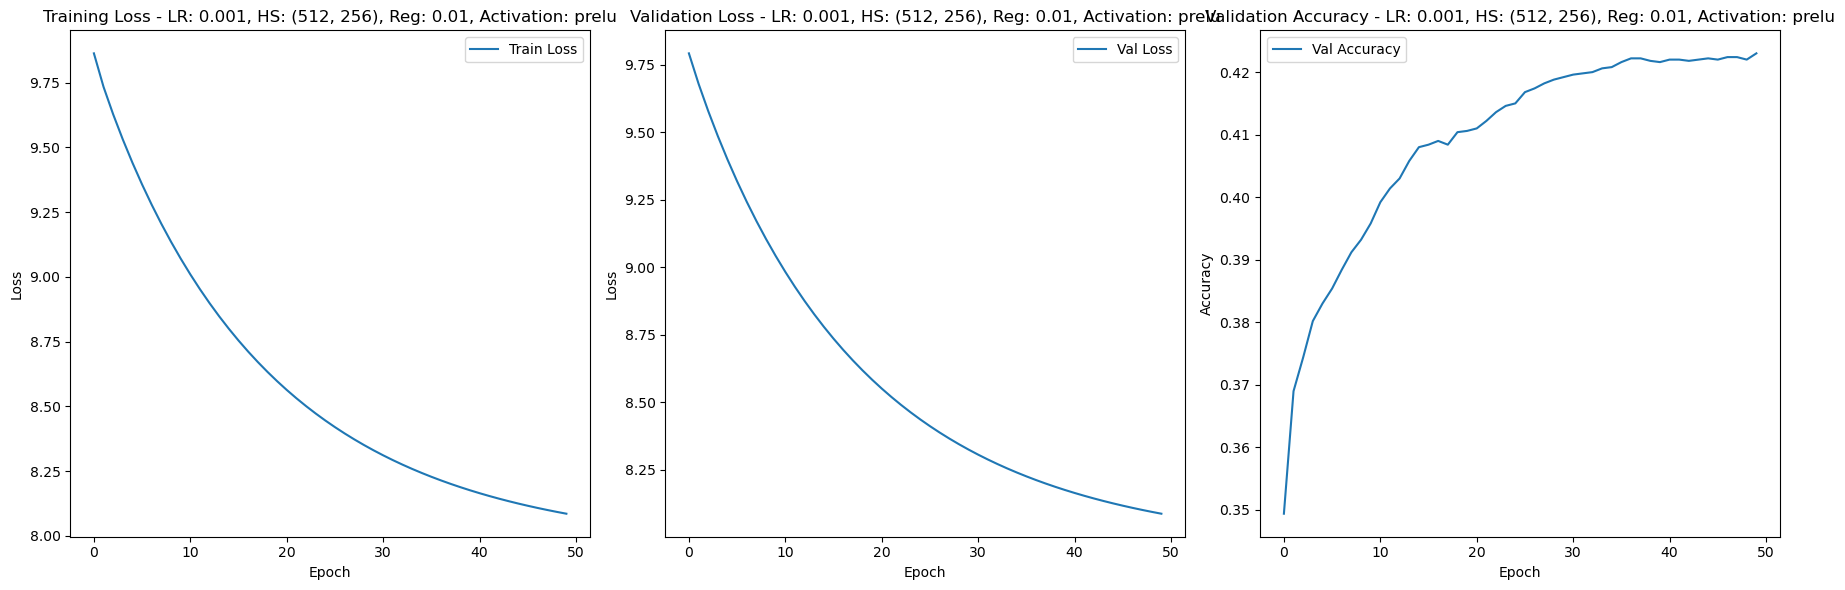

Test Accuracy: 0.4329


In [ ]:
if __name__ == '__main__':
    # 数据处理
    data_dir = "C:/Users/shubi/Desktop/cifar-10-batches-py"  
    X_train, y_train, X_test, y_test = load_cifar10(data_dir)
    X_train, X_test = preprocess_data(X_train, X_test)

    # 划分验证集
    val_idx = np.random.choice(X_train.shape[0], 5000, replace=False)
    X_val = X_train[val_idx]
    y_val = y_train[val_idx]
    X_train = np.delete(X_train, val_idx, axis=0)
    y_train = np.delete(y_train, val_idx, axis=0)

    # 超参数搜索
    learning_rates = [5e-4, 1e-3]
    hidden_sizes = [(512, 256), (256, 128)]
    regs = [0.001, 0.01]
    activations = ['relu', 'prelu', 'leaky_relu', 'tanh']
    epochs = 60
    search_results, all_train_losses, all_val_losses, all_val_accuracies = hyperparameter_search(
        X_train, y_train, X_val, y_val,
        learning_rates, hidden_sizes, regs, activations, epochs=epochs
    )

    # 选择最优超参数训练最终模型
    best_hparams = max(search_results, key=search_results.get)
    lr, hs, reg, activation = best_hparams
    print(f"最优超参数: 学习率={lr}, 隐藏层大小={hs}, 正则化参数={reg}, 激活函数={activation}")

    final_net = ThreeLayerNet(
        input_size=32 * 32 * 3,
        hidden_size1=hs[0],
        hidden_size2=hs[1],
        num_classes=10,
        activation=activation
    )
    epochs = 50
    final_net, train_loss, val_loss, val_acc = train_model(
        final_net, X_train, y_train, X_val, y_val,
        learning_rate=lr, reg=reg, epochs=epochs, verbose=True
    )

    # 可视化不同超参数下的性能曲线
    visualize_curves(train_loss, val_loss, val_acc, best_hparams)

    # 测试
    test_accuracy = test_model(final_net, X_test, y_test)